### Obtained Perplexity: -8.68, Coherence: 0.31, Best Number of Topics= 50

In [1]:
#Basic Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from topic_model_function import *

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [52]:
#Load Dataset
df=pd.read_csv('/Users/mahika.p/OneDrive - Cornell University/Anxiety/Topic_based_Gap_Analysis/Anxiety/Data/CSV/medium_text_2018.csv')
df = df.iloc[::10, :]
#getting rid of NaN
df=df.replace(np.nan, '', regex=True)
#Combining title and text
df["Post"] = df["title"] + df["text"]
#Now that we don't need Title or Text, we drop those columns before saving the file
df=df.drop(['title', 'text'], axis = 1)

In [53]:
df=df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [54]:
df.head()

,year,Post
0,2018,10 Habits That Make Anxiety Worse (And How to ...
10,2018,"The Brain, an Organ It IsOut of order, these w..."
20,2018,The Mechanics of CopingIn my last conversation...
30,2018,01 January 2018 — The Sound of the OceanThis i...
40,2018,Essential Oils That Support Anxiety ReliefI am...


In [55]:
# Convert to list
data=df.Post.values.tolist()
# Remove new line characters
data=[re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data=[re.sub("\'", "", sent) for sent in data]

In [56]:
#Function to clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

In [57]:
#Clean up text
data_words=list(sent_to_words(data))
print(data_words[:1])

[['habits', 'that', 'make', 'anxiety', 'worse', 'and', 'how', 'to', 'avoid', 'having', 'them', 'unfortunately', 'anxiety', 'disorders', 'are', 'the', 'most', 'common', 'form', 'of', 'mental', 'illness', 'in', 'the', 'united', 'states', 'affecting', 'million', 'adults', 'over', 'the', 'age', 'of', 'roughly', 'of', 'the', 'population', 'anxiety', 'costs', 'more', 'than', 'billion', 'annually', 'in', 'mental', 'health', 'bills', 'which', 'shows', 'just', 'how', 'widespread', 'and', 'severe', 'this', 'disorder', 'has', 'become', 'with', 'so', 'many', 'people', 'suffering', 'from', 'anxiety', 'it', 'seems', 'of', 'utmost', 'importance', 'to', 'find', 'the', 'triggers', 'for', 'this', 'disorder', 'and', 'how', 'we', 'can', 'avoid', 'them', 'what', 'can', 'we', 'do', 'to', 'feel', 'better', 'you', 'll', 'find', 'the', 'answers', 'to', 'this', 'question', 'in', 'this', 'article', 'as', 'well', 'as', 'the', 'actual', 'habits', 'that', 'make', 'anxiety', 'worse', 'in', 'general', 'overthinking',

In [58]:
# Build the bigram and trigram models
bigram=gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram=gensim.models.Phrases(bigram[data_words], threshold=100)

In [59]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod=gensim.models.phrases.Phraser(bigram)
trigram_mod=gensim.models.phrases.Phraser(trigram)

In [60]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['habits', 'that', 'make', 'anxiety', 'worse', 'and', 'how', 'to', 'avoid', 'having', 'them', 'unfortunately', 'anxiety', 'disorders', 'are', 'the', 'most', 'common', 'form', 'of', 'mental_illness', 'in', 'the', 'united_states', 'affecting', 'million', 'adults', 'over', 'the', 'age', 'of', 'roughly', 'of', 'the', 'population', 'anxiety', 'costs', 'more', 'than', 'billion', 'annually', 'in', 'mental_health', 'bills', 'which', 'shows', 'just', 'how', 'widespread', 'and', 'severe', 'this', 'disorder', 'has', 'become', 'with', 'so', 'many', 'people', 'suffering', 'from', 'anxiety', 'it', 'seems', 'of', 'utmost', 'importance', 'to', 'find', 'the', 'triggers', 'for', 'this', 'disorder', 'and', 'how', 'we', 'can', 'avoid', 'them', 'what', 'can', 'we', 'do', 'to', 'feel', 'better', 'you', 'll', 'find', 'the', 'answers', 'to', 'this', 'question', 'in', 'this', 'article', 'as', 'well', 'as', 'the', 'actual', 'habits', 'that', 'make', 'anxiety', 'worse', 'in', 'general', 'overthinking', 'literall

In [61]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [62]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [67]:
# data_words_nostops = remove_stopwords(data_words)
# print("1")
# data_words_bigrams = make_bigrams(data_words_nostops)
# print("2")

# # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# nlp = spacy.load("en_core_web_sm")

# # 1. Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# print("3")

# # 2. Create Dictionary needed for topic modelling
# id2word = corpora.Dictionary(data_lemmatized)
# print("4")

# # 3. Create Corpus
# texts = data_lemmatized

# # 4. Term Document Frequency and Create a bag of words
# bow_corpus = bow(dictionary=id2word, processed_docs=texts)
# print("5")

# # 5. Calculate low_tfidf_words
# # Keep only words with tfidf ranking <= x * len(dictionary)
# x = 0.2
# total_word_count, DictDocFreq = tf_df(bow_corpus, id2word)
# print("6")
# sorted_TFIDF = sort_tfidf(bow_corpus, total_word_count, DictDocFreq)
# print("7")
# low_tfidf_words = get_low_tfidf_words(x, id2word, sorted_TFIDF)
# print("8")

# # 6. Filter out least frequently used words
# no_below = 0.02
# keep_n = 10000
# dict_least_freq_filtered = filter_least_frequent(id2word, texts, 
#                                                  no_below, keep_n)
# print("9")

# # 7. Filter out most commonly used words (i.e. words with low TF-IDF score)
# dict_tfidf_filtered = filter_most_common(dict_least_freq_filtered, low_tfidf_words)
# print("10")

# # 8. Create the second bag of words - bow_corpus_TFIDFfiltered, 
# # created after least frequently and most commonly used words were filtered out.
# corpus = bow(dict_tfidf_filtered, texts)
# print("11")

# # View
# [[(dict_tfidf_filtered[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dict_tfidf_filtered,
                                           num_topics=44,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [68]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(40,
  '0.001*"scroll" + 0.001*"spiral" + 0.001*"prevent" + 0.001*"quick" + '
  '0.001*"regardless" + 0.001*"resolve" + 0.001*"opposite" + 0.001*"shame" + '
  '0.001*"urge" + 0.001*"stuck"'),
 (9,
  '0.001*"scroll" + 0.001*"spiral" + 0.001*"prevent" + 0.001*"quick" + '
  '0.001*"regardless" + 0.001*"resolve" + 0.001*"opposite" + 0.001*"shame" + '
  '0.001*"urge" + 0.001*"stuck"'),
 (2,
  '0.001*"scroll" + 0.001*"spiral" + 0.001*"prevent" + 0.001*"quick" + '
  '0.001*"regardless" + 0.001*"resolve" + 0.001*"opposite" + 0.001*"shame" + '
  '0.001*"urge" + 0.001*"stuck"'),
 (20,
  '0.001*"scroll" + 0.001*"spiral" + 0.001*"prevent" + 0.001*"quick" + '
  '0.001*"regardless" + 0.001*"resolve" + 0.001*"opposite" + 0.001*"shame" + '
  '0.001*"urge" + 0.001*"stuck"'),
 (28,
  '0.001*"scroll" + 0.001*"spiral" + 0.001*"prevent" + 0.001*"quick" + '
  '0.001*"regardless" + 0.001*"resolve" + 0.001*"opposite" + 0.001*"shame" + '
  '0.001*"urge" + 0.001*"stuck"'),
 (22,
  '0.001*"scroll" + 0.001*"spir

In [69]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -7.676814010314672


In [70]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dict_tfidf_filtered, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.37925329916761685


In [71]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df=pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row=row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row=sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:  # => dominant topic
                wp=ldamodel.show_topic(topic_num)
                topic_keywords=", ".join([word for word, prop in wp])
                sent_topics_df=sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [72]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.1907,"however, disorder, use, symptom, include, beha...","[habit, make, anxiety, bad, avoid, unfortunate..."
1,1,43.0,0.2711,"year, friend, talk, first, lot, still, week, t...","[brain, organ, isout, order, word, take, forma..."
2,2,43.0,0.4221,"year, friend, talk, first, lot, still, week, t...","[mechanic, copingin, last, conversation, gramp..."
3,3,43.0,0.4479,"year, friend, talk, first, lot, still, week, t...","[january, sound, new, project, start, new, yea..."
4,4,14.0,0.3343,"mood, patient, significant, mental_health, pro...","[essential_oil, support, anxiety, reliefi, sha..."


In [73]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.1907,"however, disorder, use, symptom, include, beha...","[habit, make, anxiety, bad, avoid, unfortunate..."
1,1,43.0,0.2711,"year, friend, talk, first, lot, still, week, t...","[brain, organ, isout, order, word, take, forma..."
2,2,43.0,0.4221,"year, friend, talk, first, lot, still, week, t...","[mechanic, copingin, last, conversation, gramp..."
3,3,43.0,0.4479,"year, friend, talk, first, lot, still, week, t...","[january, sound, new, project, start, new, yea..."
4,4,14.0,0.3343,"mood, patient, significant, mental_health, pro...","[essential_oil, support, anxiety, reliefi, sha..."
...,...,...,...,...,...
639,639,43.0,0.4978,"year, friend, talk, first, lot, still, week, t...","[good, friend, help, lose, jobtrigg, warning, ..."
640,640,43.0,0.3252,"year, friend, talk, first, lot, still, week, t...","[anxietyuno, mis, ano, nuevo, fue, compartir, ..."
641,641,42.0,0.2245,"change, meditation, practice, gratitude, focus...","[genius, app, anxiety, need, downloadanxiety, ..."
642,642,35.0,0.2905,"room, tell, leave, away, face, eye, pain, door...","[seed, social, anxiety, entryi, feel, slight, ..."


In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(5,5), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

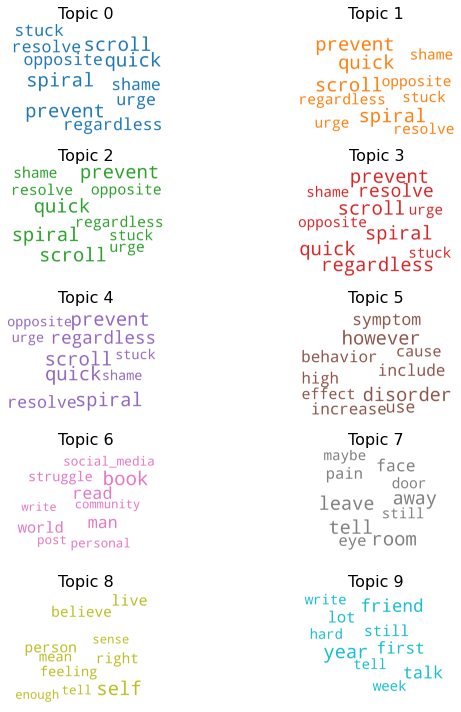

In [74]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [75]:
df_dominant_topic.to_csv("Medium2018.csv")

In [64]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(alpha='auto', corpus=corpus, num_topics=num_topics, 
                                                id2word=dictionary, random_state=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [65]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dict_tfidf_filtered, corpus=corpus, 
                                                        texts=data_lemmatized, start=2, limit=100, step=6)


range(2, 100, 6)
[0.4254655362692674, 0.3635186432566275, 0.3571198970573902, 0.35513748127998046, 0.3557723497820075, 0.3476863977110459, 0.3438076814713477, 0.3492693136809675, 0.3364948559504193, 0.3367756016744421, 0.3368939250542269, 0.3381165887472013, 0.33075002354386457, 0.33137967031408, 0.3296830606006802, 0.3310048650060942, 0.32972481695309924]


(44, 0.00546163220961976, 0.3492693136809675)

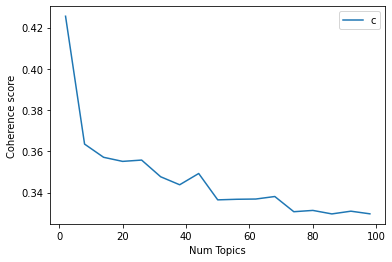

In [66]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
print(x)
print(coherence_values)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

def differences(values, x):
    """
    Returns (optimal number of topics, largest jump, coherance value after jump)
    Params:
        values: list of coherance numbers, 
        x: num topics
    """
    max_diff = (0,0,0)
    for i in range(1,len(values)):
        if values[i]-values[i-1] > max_diff[1]:
            max_diff = (x[i], values[i]-values[i-1], values[i])
    return max_diff

differences(coherence_values, x)